In [21]:
import numpy as np
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

import os
import sys  

root = os.getcwd() + "/.."

sys.path.insert(0, root)

import rasterio
import rasterio.plot

import src.manageExperiments as me
#importlib.reload(me)

In [22]:
fn = "bratislava_experiment.txt"
setup = me.readConfigFile(fn)


In [23]:
image = "../data/" + setup["folder_input"] + setup["input_ntli"]


In [24]:
tiff = rasterio.open(image)

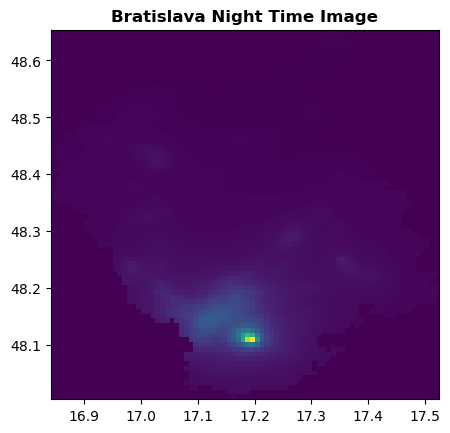

<Axes: title={'center': 'Bratislava Night Time Image'}>

In [25]:
rasterio.plot.show(tiff, title = "Bratislava Night Time Image")

In [26]:
#location of Lamhar's Light Quality Meter in format (lat, lon)
sensor_location = np.array([17.074642, 48.171667])

In [27]:
M = np.array([[tiff.transform[0], tiff.transform[1], tiff.transform[2]],[tiff.transform[3], tiff.transform[4], tiff.transform[5]]])

In [36]:
coord = np.linalg.inv(M[:,0:2])@(sensor_location-M[:,2])
print("Location of Lamphars coordinate in the matrix in [lat, lon]: ", coord)

Location of Lamphars coordinate in the matrix in [lat, lon]:  [27.96649959 57.90175409]


# Read the raster file

In [84]:
import src.manageExperiments as me

import src.positioning_sensors as ps
#importlib.reload(me)

import config.config as cfg

import src.regionGrowing as rg

import pandas as pd

import scipy as sp

In [85]:
fn = "bratislava_experiment.txt"
me.createProject(fn)

Read File: ../experiments/bratislava_experiment.txt
Creating Directory in: ../experiments/bratislava_experiment/
Creating Directory ../experiments/bratislava_experiment/results/
Creating Directory: ../experiments/bratislava_experiment/semivariances/
Copy bratislava_experiment.txt -> ../experiments/bratislava_experiment/bratislava_experiment.txt


In [86]:
flat_means_decrease = bool(setup['flatness_means_decrease'])
print(flat_means_decrease)

True


In [87]:
#NTLI: luminance
ilumina = cfg.data + setup["folder_input"] + setup["input_ntli"]
NTLI = ps.readIMG(ilumina)


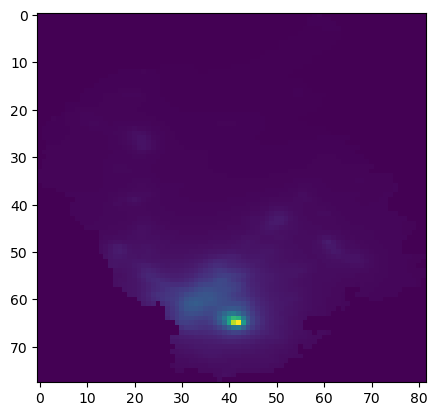

In [88]:

plt.imshow(NTLI)

In [89]:
#smoothing parameters
sigma_y = setup['filterg_sy']
sigma_x =setup['filterg_sx']
sigma = [sigma_y, sigma_x]

FDNTLI = sp.ndimage.filters.gaussian_filter(NTLI, 
                                            sigma, 
                                            mode = setup['gaussian_mode'])


#we filter only the values greater than 22
FDNTLI = (FDNTLI>=setup['neglect_values'])*FDNTLI

nonsatc = np.copy(FDNTLI)

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_51482/3319945585.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  FDNTLI = sp.ndimage.filters.gaussian_filter(NTLI,


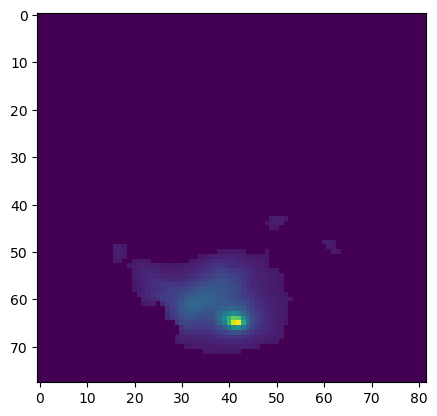

In [90]:
plt.imshow(FDNTLI)

In [91]:
si = tuple(np.round(coord).astype(int)[::-1])

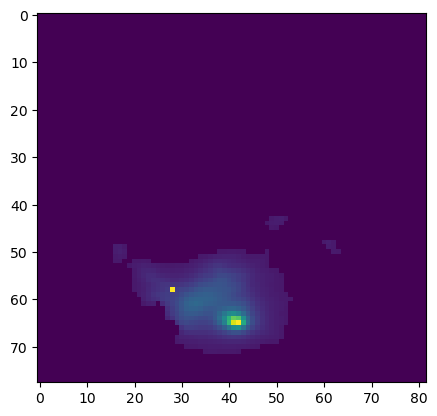

In [92]:
FDNTLI_bratislava = np.copy(FDNTLI)
FDNTLI_bratislava[si]=np.max(FDNTLI_bratislava)

plt.imshow(FDNTLI_bratislava)

In [93]:
params = {"type": "semivar", 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(FDNTLI.shape)

#tell to the class, which object is going to be used to make the semivariogram

rG = rg.rGrowing(FDNTLI)

rG.setParams(params)

n = len(coord)

#ncords x imagesize m x n
image_size = (n, FDNTLI.shape[0]*FDNTLI.shape[1])
allsemivariances = np.zeros(image_size)
allmask = np.zeros(image_size)


df = pd.DataFrame()

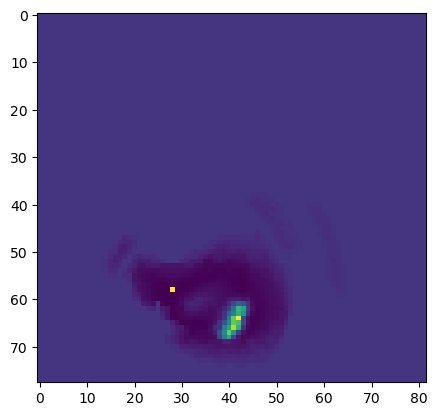

In [95]:
sv = rG.makeSemivarianceMap(si)
svc = np.copy(sv)
svc[si] = np.max(svc)
plt.imshow(svc)

In [103]:
print("coords:", si)
    
si = tuple(si)

#generate a semivariance sv map
sv = rG.makeSemivarianceMap(si)
    
#flattne sv to store it in a dataframe
semivar_brat = sv.flatten()
    
#construct a mask of sv and then flatten it
semivar_brat_mask = ps.constructMask(si, sv, flat_means_decrease).flatten()

coords: (58, 28)


In [104]:
maskf = ps.constructMask(si, sv, flat_means_decrease).flatten()

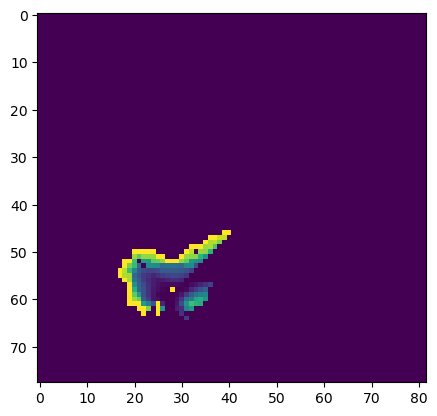

In [114]:
image_mask = maskf.reshape(sv.shape)*sv
image_mask[si] = np.max(image_mask)
plt.imshow(image_mask)

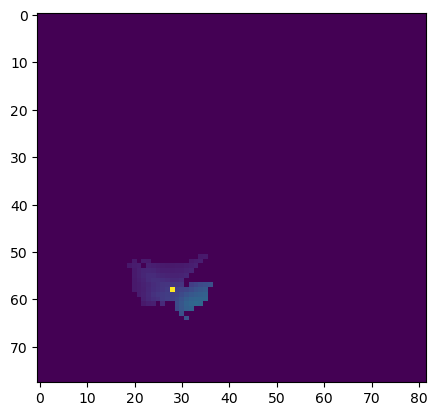

In [115]:
#image_mask = maskf.reshape(sv.shape)*sv
FDNTLI[si] = np.max(FDNTLI)

plt.imshow(maskf.reshape(sv.shape)*FDNTLI)